## Microsoft Original Content Recommendations

Please fill out:
* Student name: Austin Murray
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Yish
* Blog post URL:


## Overview
Microsoft has created its own studio to make original movies. We are analyzing english movies from the last five years to give a recommendation to microsoft on what choices to make for runtime, genre, filmming locations, and when to release the movie. These are important to give as this will give them the where when and what about to create a profitable movie based on what current movie goers want to see. 

## The Data
The data being used in this analysis is coming from:
IMDB
TMDB
Rotten tomatoes

These are the biggest movie rating and information databases on the internet.
We will be anaylizing the last five years of englishing speaking movies with at least 100 votes and under 350 minutes of runtime.
Variables we will be looking for are profit/genre, profit/month, rating/genre rating/runtime, numvotes/runtime.

Importing all the tools

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import json
from datetime import date
from datetime import datetime
from dateutil.relativedelta import relativedelta
import time

Dictionary for genre id's that will be used later

In [3]:
genre_dict = {"genres":[{"id":28,"name":"Action"},{"id":12,"name":"Adventure"},{"id":16,"name":"Animation"},
                        {"id":35,"name":"Comedy"},{"id":80,"name":"Crime"},{"id":99,"name":"Documentary"},
                        {"id":18,"name":"Drama"},{"id":10751,"name":"Family"},{"id":14,"name":"Fantasy"},
                        {"id":36,"name":"History"},{"id":27,"name":"Horror"},{"id":10402,"name":"Music"},
                        {"id":9648,"name":"Mystery"},{"id":10749,"name":"Romance"},{"id":878,"name":"Science Fiction"},
                        {"id":10770,"name":"TV Movie"},{"id":53,"name":"Thriller"},{"id":10752,"name":"War"},
                        {"id":37,"name":"Western"}]}

Changing the dictionary to one that is just the Id's and names so we can use it easier later

In [5]:
genre_dict_2 = {}
for dict in range(0,len(genre_dict['genres'])):
    genre_dict_2[genre_dict['genres'][dict]['id']] = genre_dict['genres'][dict]['name']


Bringing in the data as Dataframes

In [6]:
ratings_df = pd.read_csv(r"C:\Users\murra\Documents\Flatiron_classwork\phase_1\dsc-phase-1-project-online\zippedData\imdb.title.ratings.csv.gz")
title_basics_df = pd.read_csv(r"C:\Users\murra\Documents\Flatiron_classwork\phase_1\dsc-phase-1-project-online\zippedData\imdb.title.basics.csv.gz")
gross_income_df = pd.read_csv(r"C:\Users\murra\Documents\Flatiron_classwork\phase_1\dsc-phase-1-project-online\zippedData\bom.movie_gross.csv.gz")
budgets_df = pd.read_csv(r"C:\Users\murra\Documents\Flatiron_classwork\phase_1\dsc-phase-1-project-online\zippedData\tn.movie_budgets.csv.gz")
name_basics_df = pd.read_csv(r"C:\Users\murra\Documents\Flatiron_classwork\phase_1\dsc-phase-1-project-online\zippedData\imdb.name.basics.csv.gz")
movie_info_df = pd.read_csv(r"C:\Users\murra\Documents\Flatiron_classwork\phase_1\dsc-phase-1-project-online\zippedData\rt.movie_info.tsv.gz", sep='\t')
title_crew_df = pd.read_csv(r"C:\Users\murra\Documents\Flatiron_classwork\phase_1\dsc-phase-1-project-online\zippedData\imdb.title.crew.csv.gz")
title_principals_df = pd.read_csv(r"C:\Users\murra\Documents\Flatiron_classwork\phase_1\dsc-phase-1-project-online\zippedData\imdb.title.principals.csv.gz")
tmdb_movie_info_df = pd.read_csv(r"C:\Users\murra\Documents\Flatiron_classwork\phase_1\dsc-phase-1-project-online\zippedData\tmdb.movies.csv.gz")


Combining the dataframes on columns that are the same

In [7]:
ratings_basics = pd.merge(ratings_df, title_basics_df)

In [8]:
basics_ratings_directors_df = pd.merge(ratings_basics, title_crew_df)


In [9]:
movie_and_budget = pd.merge(budgets_df, tmdb_movie_info_df, left_on='movie', right_on='title')

Deleting the dolar signs in the three columns of budget and revenue so we can make calculations with them later

In [10]:
movie_and_budget[movie_and_budget.columns[3:6]] = movie_and_budget[movie_and_budget.columns[3:6]].replace('[\$,]', '', regex=True).astype(float)

Findind the profit by taking worldwide gross and subtracting produciton profit

In [11]:
movie_and_budget['profit'] = movie_and_budget['worldwide_gross'] - movie_and_budget['production_budget']

Getting rid of any movie released before 2016 in the two release date columns

In [12]:
movie_and_budget_last_5years = movie_and_budget[movie_and_budget['release_date_y'].str.contains('2016') | 
                 movie_and_budget['release_date_y'].str.contains('2017') |
                 movie_and_budget['release_date_y'].str.contains('2018') |
                 movie_and_budget['release_date_y'].str.contains('2019') |
                 movie_and_budget['release_date_y'].str.contains('2020')]

In [13]:
movie_and_budget_last_5years = movie_and_budget_last_5years[movie_and_budget_last_5years['release_date_x'].str.contains('2016') | 
                 movie_and_budget_last_5years['release_date_x'].str.contains('2017') |
                 movie_and_budget_last_5years['release_date_x'].str.contains('2018') |
                 movie_and_budget_last_5years['release_date_x'].str.contains('2019') |
                 movie_and_budget_last_5years['release_date_x'].str.contains('2020')]

Dropping any duplicate movies

In [50]:
movie_and_budget_last_5years = movie_and_budget_last_5years.drop_duplicates(subset=['id_x','id_y'])

Containing only english as original language as microsoft will be making a movie for the american market

In [51]:
movie_and_budget_last_5years = movie_and_budget_last_5years[movie_and_budget_last_5years['original_language'].str.contains('en')]

Changing the release_date_y column from string to date and pulling out the month into its own column

In [52]:
movie_and_budget_last_5years['release_date_y']= pd.to_datetime(movie_and_budget_last_5years['release_date_y'])

In [53]:
movie_and_budget_last_5years['month'] = pd.to_datetime(movie_and_budget_last_5years['release_date_y']).dt.month

Splitting the genre_ids into their own columns for each one

In [44]:
movie_and_budget_last_5years['genre_ids'] = movie_and_budget_last_5years['genre_ids'].str.replace(",","").str.replace("]","").str.replace("[","").str.split()

In [46]:

movie_and_budget_last_5years = movie_and_budget_last_5years.join(pd.DataFrame(movie_and_budget_last_5years["genre_ids"].values.tolist(), movie_and_budget_last_5years.index).add_prefix('genre_'))



Changing the genre ids in their own columns to intergers instead of strings to match the dictionary we made at the beginning

In [47]:
for y in range(0,7):
    movie_and_budget_last_5years['genre_'+str(y)] = pd.to_numeric(movie_and_budget_last_5years['genre_'+str(y)], errors='coerce')

Mapping the dictionary from the beginning to give us the genres related to each number

In [55]:
for y in range(0,7):
    movie_and_budget_last_5years['genre_'+str(y)] = movie_and_budget_last_5years['genre_'+str(y)].map(genre_dict_2)


Creating dataframes to graph and find the most profitable month to release a movie

In [76]:
avg_profit = movie_and_budget_last_5years.groupby(['month']).mean().sort_values(by=['profit'], ascending=False)
median_profit = movie_and_budget_last_5years.groupby(['month']).median().sort_values(by=['profit'], ascending=False)
std_profit = movie_and_budget_last_5years.groupby(['month']).std().sort_values(by=['profit'], ascending=False)

giving each genre for a row its own row allowing us to get profit information for each genre

In [80]:
split_by_genre = movie_and_budget_last_5years.melt(id_vars=['id_x', 'release_date_x', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'Unnamed: 0', 'genre_ids', 'id_y',
       'original_language', 'original_title', 'popularity', 'release_date_y',
       'title', 'vote_average', 'vote_count', 'profit', 'month'], 
        var_name="gen_x", 
        value_name="Genres")

In [68]:
avg_profit_genre = split_by_genre.groupby(['Genres']).mean().sort_values(by=['profit'], ascending=False)
median_profit_genre = split_by_genre.groupby(['Genres']).median().sort_values(by=['profit'], ascending=False)
std_profit_genre = split_by_genre.groupby(['Genres']).std().sort_values(by=['profit'])

Deleting any movie with less than 100 votes and before 2016

In [69]:
ratings_basics.drop(ratings_basics[ratings_basics['numvotes'] < 100].index, inplace = True)

In [70]:
ratings_basics.drop(ratings_basics[ratings_basics['start_year'] < 2016].index, inplace = True)

Breaking the genre column into its own columns

In [83]:
genres = ratings_basics["genres"].str.split(",", expand = True)

In [85]:
ratings_basics_genre = pd.concat([ratings_basics, genres], axis=1)


In [86]:
ratings_basics_genre.rename(columns={0: "genre_0", 1: "genre_1", 2: "genre_2"}, inplace=True)

Creating a row for every genre in a row to create genre information

In [95]:
ratings_basics_genre = ratings_basics_genre.melt(id_vars=['tconst', 'averagerating', 'numvotes', 'primary_title',
       'original_title', 'start_year', 'runtime_minutes', 'genres'], 
        var_name="gen_x", 
        value_name="Genres_long")

In [96]:
runtime_ratings = ratings_basics_genre.groupby(['runtime_minutes']).mean()

Getting rid of any movie with more than 350 minutes of runtime

In [97]:
runtime_ratings.drop(runtime_ratings[runtime_ratings.index > 350].index, inplace = True)

In [90]:
avg_rating_by_genre = ratings_basics_genre.groupby(['Genres_long']).mean().sort_values(by=['averagerating'], ascending=False)
median_rating_by_genre = ratings_basics_genre.groupby(['Genres_long']).median().sort_values(by=['averagerating'], ascending=False)
std_rating_by_genre = ratings_basics_genre.groupby(['Genres_long']).std().sort_values(by=['averagerating'])

avg_numvotes_by_genre = ratings_basics_genre.groupby(['Genres_long']).mean().sort_values(by=['numvotes'], ascending=False)
median_numvotes_by_genre = ratings_basics_genre.groupby(['Genres_long']).median().sort_values(by=['numvotes'], ascending=False)
std_numvotes_by_genre = ratings_basics_genre.groupby(['Genres_long']).std().sort_values(by=['numvotes'])

Creating graphs to see which month is the best to relase a movie based on profit

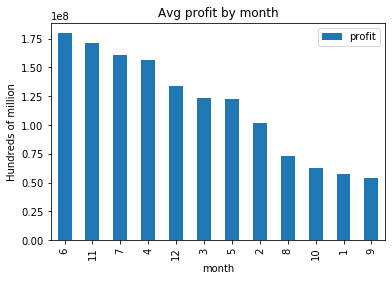

In [91]:
avg_profit[['profit']].plot(kind='bar')
plt.title('Avg profit by month')
plt.ylabel('Hundreds of million');

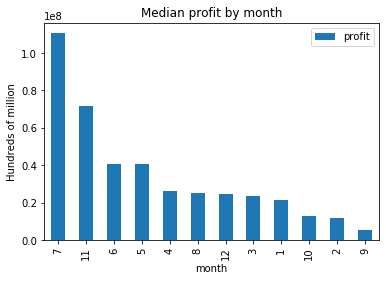

In [92]:
median_profit[['profit']].plot(kind='bar')
plt.title('Median profit by month')
plt.ylabel('Hundreds of million');

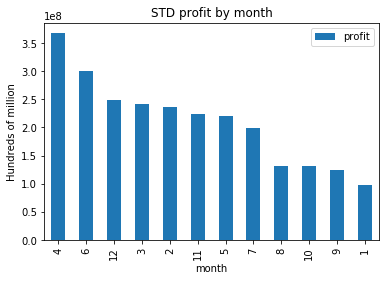

In [93]:
std_profit[['profit']].plot(kind='bar')
plt.title('STD profit by month')
plt.ylabel('Hundreds of million');

Creating graphs to see the genre that makes the most money and how many movies of each genre were made

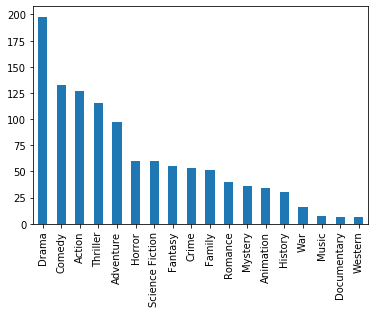

In [94]:
movie_and_budget_last_5years[['genre_0', 'genre_1','genre_2','genre_3']].apply(pd.Series.value_counts).sum(axis=1).sort_values(ascending=False).plot(kind='bar');

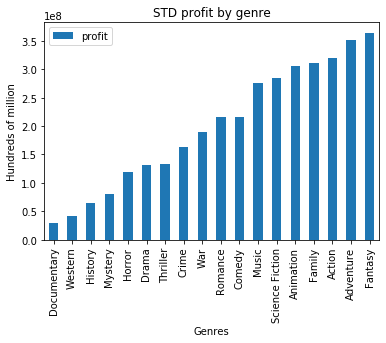

In [203]:
std_profit_genre[['profit']].plot(kind='bar')
plt.title('STD profit by genre')
plt.ylabel('Hundreds of million');

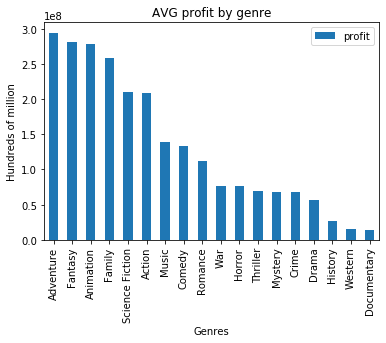

In [196]:
avg_profit_genre[['profit']].plot(kind='bar')
plt.title('AVG profit by genre')
plt.ylabel('Hundreds of million');

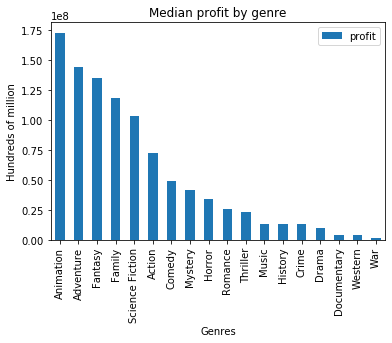

In [197]:
median_profit_genre[['profit']].plot(kind='bar')
plt.title('Median profit by genre')
plt.ylabel('Hundreds of million');

Graph of runtime against ratings

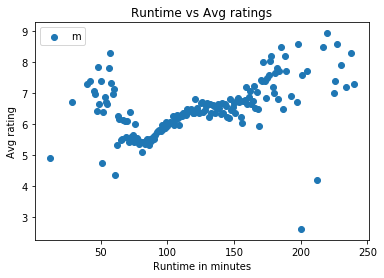

In [101]:
plt.scatter(runtime_ratings.index,runtime_ratings['averagerating']);
plt.title('Runtime vs Avg ratings')
plt.xlabel('Runtime in minutes')
plt.ylabel('Avg rating')
plt.legend('movie');

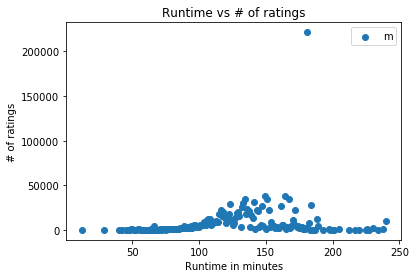

In [102]:
plt.scatter(runtime_ratings.index,runtime_ratings['numvotes'])
plt.title('Runtime vs # of ratings')
plt.xlabel('Runtime in minutes')
plt.ylabel('# of ratings')
plt.legend('movie');

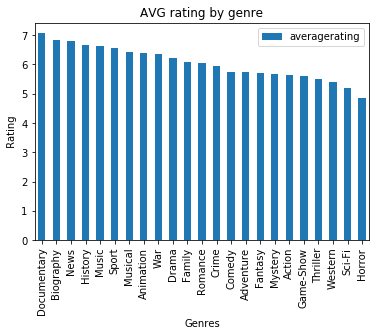

In [103]:
avg_rating_by_genre[['averagerating']].plot(kind='bar')
plt.title('AVG rating by genre')
plt.ylabel(' Rating ')
plt.xlabel('Genres');

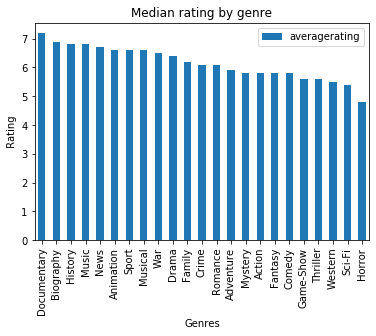

In [104]:
median_rating_by_genre[['averagerating']].plot(kind='bar')
plt.title('Median rating by genre')
plt.ylabel(' Rating ')
plt.xlabel('Genres');

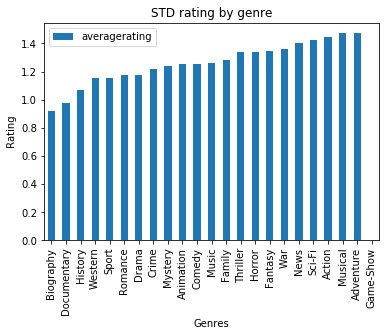

In [105]:
std_rating_by_genre[['averagerating']].plot(kind='bar')
plt.title('STD rating by genre')
plt.ylabel(' Rating ')
plt.xlabel('Genres');

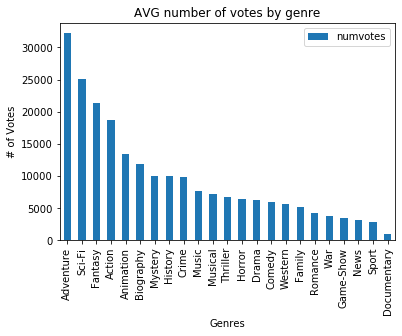

In [106]:
avg_numvotes_by_genre[['numvotes']].plot(kind='bar')
plt.title('AVG number of votes by genre')
plt.ylabel('# of Votes')
plt.xlabel('Genres');

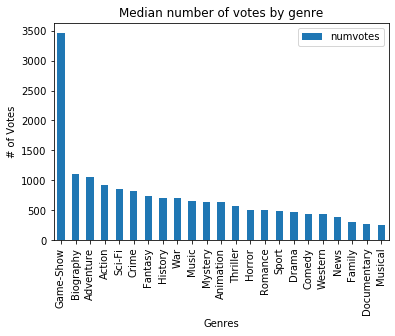

In [107]:
median_numvotes_by_genre[['numvotes']].plot(kind='bar')
plt.title('Median number of votes by genre')
plt.ylabel('# of Votes')
plt.xlabel('Genres');

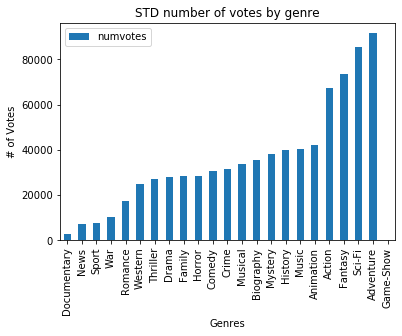

In [108]:
std_numvotes_by_genre[['numvotes']].plot(kind='bar')
plt.title('STD number of votes by genre')
plt.ylabel('# of Votes')
plt.xlabel('Genres');

Getting data for July since it is the most profitable with a lower STD

In [109]:
months = movie_and_budget_last_5years.groupby(['month'])

In [110]:
July = months.get_group(7)

In [111]:
July_genre_count = July[['genre_0', 'genre_1','genre_2','genre_3']].apply(pd.Series.value_counts).sum(axis=1)

In [112]:
July_split_by_genre = July.melt(id_vars=['id_x', 'release_date_x', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'Unnamed: 0', 'genre_ids', 'id_y',
       'original_language', 'original_title', 'popularity', 'release_date_y',
       'title', 'vote_average', 'vote_count', 'profit', 'month'], 
        var_name="gen_x", 
        value_name="Genres")

In [113]:
July_avg_profit_genre = July_split_by_genre.groupby(['Genres']).mean().sort_values(by=['profit'], ascending=False)
July_median_profit_genre = July_split_by_genre.groupby(['Genres']).median().sort_values(by=['profit'], ascending=False)
July_std_profit_genre = July_split_by_genre.groupby(['Genres']).std().sort_values(by=['profit'])

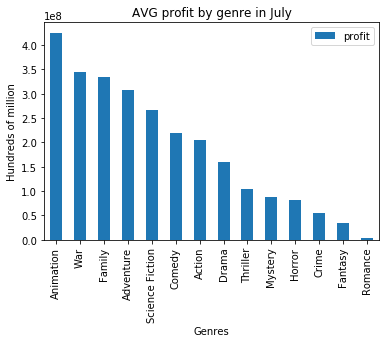

In [115]:
July_avg_profit_genre[['profit']].plot(kind='bar')
plt.title('AVG profit by genre in July')
plt.ylabel('Hundreds of million');

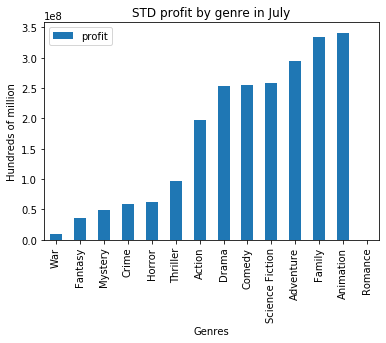

In [116]:
July_std_profit_genre[['profit']].plot(kind='bar')
plt.title('STD profit by genre in July')
plt.ylabel('Hundreds of million');

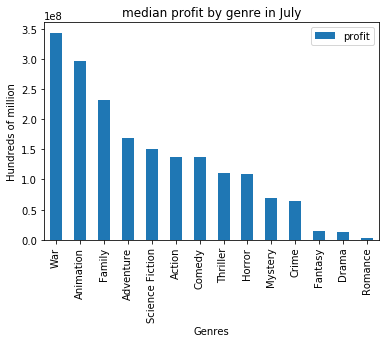

In [117]:
July_median_profit_genre[['profit']].plot(kind='bar')
plt.title('median profit by genre in July')
plt.ylabel('Hundreds of million');